In [ ]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

## defining a frame for image and mask storage

In [ ]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgNames = os.listdir('drive/MyDrive/ColabData/SelfDrivingCar/Train')
maskNames = os.listdir('drive/MyDrive/ColabData/SelfDrivingCar/Train_Mask')

len(imgNames)

398

In [ ]:
len(maskNames)

367

In [ ]:
imgNames_new = []
for j in range(len(maskNames)):
  if maskNames[j] in imgNames:
    imgNames_new.append(maskNames[j])

In [ ]:
len(imgNames_new)

367

In [ ]:
def LoadData(frameObj = None, imgList = None, maskList = None, imgPath = None, maskPath = None,  shape = 125):

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgList)):
        img = plt.imread(imgAddr + imgList[i])
        mask = plt.imread(maskAddr + maskList[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        # Ensure mask has 3 channels if it's 2D
        #if mask.ndim == 2:
        #    mask = np.stack([mask, mask, mask], axis=-1)

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

Data Preparation

In [ ]:
framObjTrain = LoadData( framObjTrain, imgList = imgNames_new, maskList = maskNames, imgPath = 'drive/MyDrive/ColabData/SelfDrivingCar/Train', maskPath = 'drive/MyDrive/ColabData/SelfDrivingCar/Train_Mask'
                          , shape = 125)

In [ ]:
imgNames_test = os.listdir('drive/MyDrive/ColabData/SelfDrivingCar/Test')
maskNames_test = os.listdir('drive/MyDrive/ColabData/SelfDrivingCar/Test_Mask')

In [ ]:
maskNames_test_new = []
for j in range(len(imgNames_test)):
  if imgNames_test[j] in maskNames:
    maskNames_test_new.append(imgNames[j])

In [ ]:
len(imgNames_test)

101

In [ ]:
len(maskNames_test)

101

In [ ]:
framObjValidation  = LoadData(framObjValidation, imgList = imgNames_test, maskList = maskNames_test, imgPath='drive/MyDrive/ColabData/SelfDrivingCar/Test', maskPath='drive/MyDrive/ColabData/SelfDrivingCar/Test_Mask'
         , shape = 125)

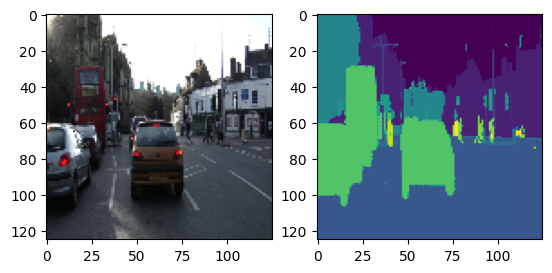

In [ ]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

# this block essentially performs 2 convolution

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

# Now defining Unet

In [ ]:
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])

    return model

# Instance model



In [ ]:
import tensorflow.keras.backend as K

def custom_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    return K.mean(loss)

inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.build((None, 256, 256, 3))
myTransformer.compile(optimizer = 'Adam', loss = custom_binary_crossentropy, metrics = ['accuracy'] )

Training Our Model

In [ ]:
import numpy as np
train_images = np.array(framObjTrain['img'])
train_masks = np.array(framObjTrain['mask'])

# Ensure train_masks has 3 channels for consistency with the U-Net model output and expected input shape for tf.image.resize
if train_masks.ndim == 3: # If masks are (batch, height, width) (grayscale)
    train_masks = np.expand_dims(train_masks, axis=-1) # Add channel dimension -> (batch, height, width, 1)
    train_masks = np.repeat(train_masks, 3, axis=-1) # Repeat channel to make it 3-channel -> (batch, height, width, 3)
elif train_masks.ndim == 4 and train_masks.shape[-1] == 1: # If masks are (batch, height, width, 1)
    train_masks = np.repeat(train_masks, 3, axis=-1) # Repeat channel to make it 3-channel -> (batch, height, width, 3)
# If train_masks is already (batch, height, width, 3), no change needed.

# The masks are already in [0, 1] range based on plt.imread, so no need to divide by 255.0
# train_masks = train_masks / 255.0

# Resize images and masks to 256x256
resized_train_images = tf.image.resize(train_images, (256, 256)).numpy()
resized_train_masks = tf.image.resize(train_masks, (256, 256)).numpy()

# Temporarily disable tf.function to get more verbose error messages
tf.config.run_functions_eagerly(True)

retVal = myTransformer.fit(resized_train_images, resized_train_masks, epochs = 30, verbose = 0)

# Re-enable tf.function after training if desired
tf.config.run_functions_eagerly(False)

In [ ]:
len(framObjTrain['img'])

367

In [ ]:
len(framObjTrain['mask'])

367

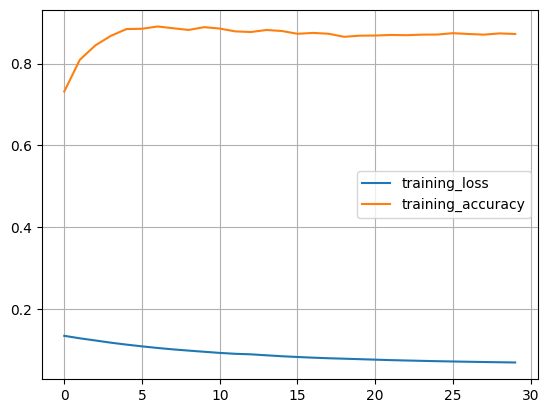

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

## function for getting 16 predictions

In [ ]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    # Resize images to the model's expected input shape
    imgProc = tf.image.resize(imgProc, (shape, shape)).numpy()

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask

In [ ]:
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


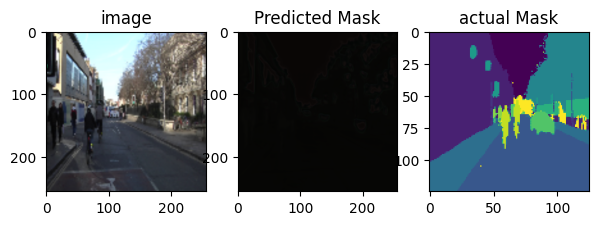

In [ ]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

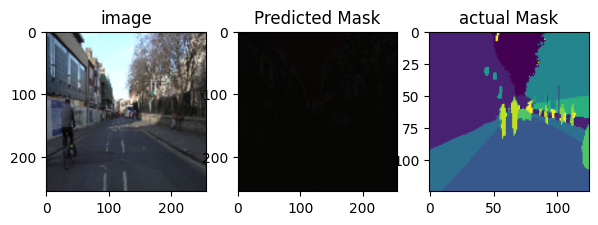

In [ ]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

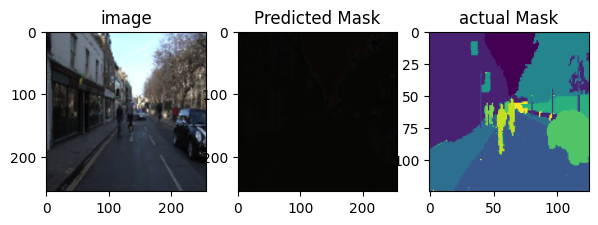

In [ ]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

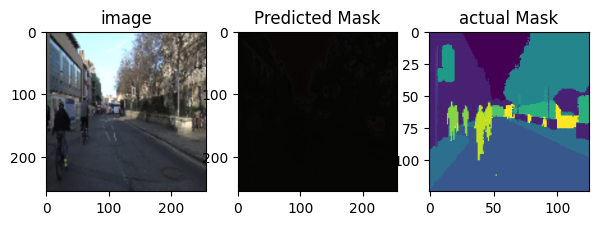

In [ ]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])